In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

New_df = pd.read_csv("assets/datasets/processed_data_noSClaing.csv")



In [3]:
features = ['Leaf wetness probability_mean_filled','Relative Humidity_max', 
            'Soil Moisture_mean', 'Soil Temperature_mean', 'Sunshine Duration_mean',
            'state','district', 'subdistrict', 'crop', 
            'month']

In [4]:
# Splitting 
X = New_df[features]
y = New_df['target']

In [5]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X= scaler.fit_transform(X)


import joblib
# Save the scaler
joblib.dump(scaler, 'assets/models/scaler.pkl')

['assets/models/scaler.pkl']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
num_classes = len(np.unique(y))

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization


In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for the target variable
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary format for Keras
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 2.3710280373831774, 1: 2.0255489021956086, 2: 2.475121951219512, 3: 0.5140830800405268, 4: 1.0461855670103093, 5: 0.8164119066773934, 6: 1.0021066491112574, 7: 0.5307531380753138, 8: 2.737769784172662, 9: 0.7649246231155779}


In [10]:
# Model architecture
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # 10-class classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,y_train,
    #X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
    class_weight=class_weight_dict,

)

#model.summary()


Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1528 - loss: 2.7581 - val_accuracy: 0.2945 - val_loss: 1.8661
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2618 - loss: 2.0242 - val_accuracy: 0.3579 - val_loss: 1.6662
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3036 - loss: 1.8766 - val_accuracy: 0.3789 - val_loss: 1.5854
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3139 - loss: 1.7513 - val_accuracy: 0.3771 - val_loss: 1.5292
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3250 - loss: 1.6719 - val_accuracy: 0.3840 - val_loss: 1.4894
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3313 - loss: 1.6201 - val_accuracy: 0.3833 - val_loss: 1.4570
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3415 - loss: 1.5427 - val_accuracy: 0.3799 - val_loss: 1.4329
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3391 - loss: 1.5267 - val_accu

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest accuracy: {test_acc:.4f}')

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))



Test accuracy: 0.3975
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.49      0.29       294
           1       0.35      0.56      0.43       353
           2       0.35      0.42      0.38       331
           3       0.52      0.12      0.20      1399
           4       0.45      0.67      0.53       699
           5       0.35      0.65      0.46       930
           6       0.64      0.28      0.39       819
           7       0.55      0.42      0.48      1485
           8       0.25      0.41      0.32       292
           9       0.36      0.33      0.34      1010

    accuracy                           0.40      7612
   macro avg       0.40      0.44      0.38      7612
weighted avg       0.45      0.40      0.38      7612



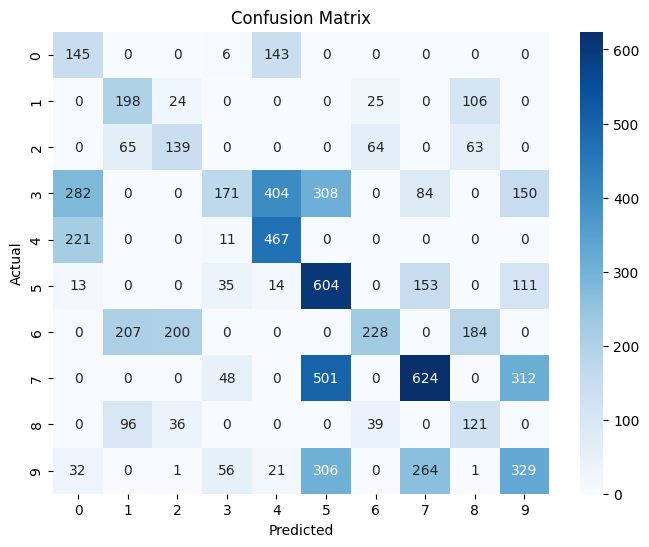

In [12]:
import seaborn as sns

import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
#model.save("assets/models/Deeplearning_class_weight_model.keras") 

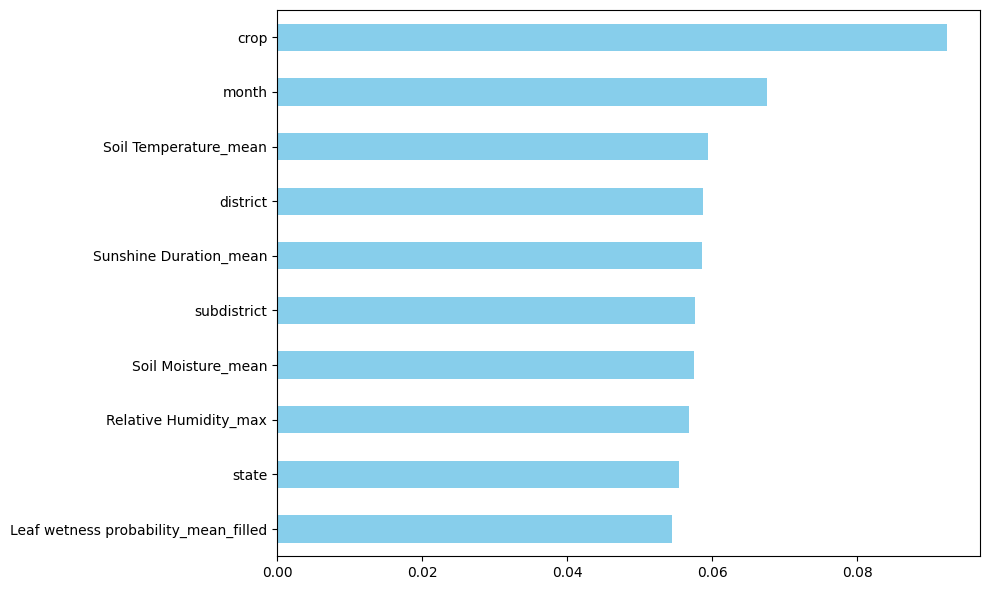

In [14]:
import matplotlib.pyplot as plt
importances = model.layers[0].get_weights()[0].std(axis=1)

feature_importance = pd.Series(importances, index=features)
feature_importance = feature_importance.abs().sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh', color='skyblue')
plt.tight_layout()
plt.show()
